# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">🖼️ Img2Prompt 📄 -  BLIP + CLIP | CLIP Interrogator</center>
<p><center style="color:#949494; font-family: consolas; font-size: 20px;">Stable Diffusion - Image to Prompts</center></p>

***

<p style="font-family: consolas; font-size: 16px;"> 🔴 The new stable diffusion model (Stable Diffusion 2.0-v) at 768x768 resolution has the same number of parameters in the U-Net as 1.5, but uses <a href="https://github.com/Stability-AI/stablediffusion#news"><strong>OpenCLIP-ViT/H</strong></a> as the text encoder and is trained from scratch. SD 2.0-v is a so-called v-prediction model.</p>

<p style="font-family: consolas; font-size: 16px;"> 🔴 This kernel explores the outcomes achievable by using the clip version (<a href="https://huggingface.co/laion/CLIP-ViT-H-14-laion2B-s32B-b79K"><strong>CLIP-ViT-H-14-laion2B-s32B-b79K</strong></a>) that was utilized in the Stable Diffusion 2.0 training. It should be emphasized that the resulting output is heavily influenced by the set of text labels chosen to compare with the image embeddings.</p>

<p style="font-family: consolas; font-size: 16px;"> 🔴 CLIP interrogator's original version has <a href="https://github.com/pharmapsychotic/clip-interrogator/tree/main/clip_interrogator/data"><strong>5 text label sets</strong></a>. When tested on the original version, I obtained a score of <b>0.44024</b>, but by simply removing the <b>artists.txt</b> and the <b>sites</b> labels lists, the score improved to <b>0.45836</b>. With experimentation using various sets and groups of lists, it is possible to achieve better performance than that of this kernel.</p>

#### <a id="top"></a>
# <div style="box-shadow: rgb(60, 121, 245) 0px 0px 0px 3px inset, rgb(255, 255, 255) 10px -10px 0px -3px, rgb(31, 193, 27) 10px -10px, rgb(255, 255, 255) 20px -20px 0px -3px, rgb(255, 217, 19) 20px -20px, rgb(255, 255, 255) 30px -30px 0px -3px, rgb(255, 156, 85) 30px -30px, rgb(255, 255, 255) 40px -40px 0px -3px, rgb(255, 85, 85) 40px -40px; padding:20px; margin-right: 40px; font-size:30px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(60, 121, 245);"><b>Table of contents</b></div>

<div style="background-color: rgba(60, 121, 245, 0.03); padding:30px; font-size:15px; font-family: consolas;">

* [1. About CLIP interrogator tool](#1)
* [2. Install & Import all dependencies](#2)
* [3. Set configs](#3)
* [4. Load the Sample Submission](#4)
* [5. Build index from images](#5)
* [6. Load the embedding model](#6)
* [7. Prepare CLIP interrogator tool](#7)
    * [7.1 Define CLIP interrogator config](#7.1)
    * [7.2 Define BLIP model](#7.2)
    * [7.3 Define CLIP model](#7.3)
    * [7.4 Create CLIP interrogator object](#7.4)
* [8. Define interrogate function](#8)
    * [8.1 Get labels embeddings](#8.1)
    * [8.2 Create main interrogation function](#8.2)
* [9. Extract promt from images](#9)
    * [9.1 Check the result](#9.1)
* [10. Create a sample submission with a constant prompt prediction](#10)
    * [10.1 Encode prompts](#10.1)
    * [10.2 Create submission DataFrame and save it as a .csv file](#10.2)

<a id="1"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 1. About CLIP interrogator tool</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ The CLIP Interrogator is a prompt engineering tool that combines OpenAI's <a href="https://openai.com/blog/clip/"><strong>CLIP</strong></a> and Salesforce's <a href="https://blog.salesforceairesearch.com/blip-bootstrapping-language-image-pretraining/"><strong>BLIP</strong></a> to optimize text prompts to match a given image.</p>

<p style="font-family: consolas; font-size: 16px;">⚪ CLIP Interrogator uses OpenCLIP which supports many different pretrained CLIP models. For the best prompts for Stable Diffusion 2.0 uses <b>ViT-H-14/laion2b_s32b_b79k</b>.</p>


<p style="font-family: consolas; font-size: 16px;">⚪ CLIP Interrogator pipeline looks as follows:</p>

* <p style="font-family: consolas; font-size: 16px;">An image is passed to the input to BLIP to obtain the main description.</p>

* <p style="font-family: consolas; font-size: 16px;">An image is passed to the input to CLIP to receive its embedding.</p>

* <p style="font-family: consolas; font-size: 16px;">Embeddings received from the image are compared with embeddings received from labels from the lists and the top 4 with the greatest similarity are selected.</p>
<p style="font-family: consolas; font-size: 16px;">There are 4 main lists on which the outgoing prompt for the CLIP part is formed: <a href="https://github.com/pharmapsychotic/clip-interrogator/blob/main/clip_interrogator/data/artists.txt"><strong>artists.txt</strong></a> (list with artists), <a href="https://github.com/pharmapsychotic/clip-interrogator/blob/main/clip_interrogator/data/flavors.txt"><strong>flavors.txt</strong></a> (main list for image description), <a href="https://github.com/pharmapsychotic/clip-interrogator/blob/main/clip_interrogator/data/mediums.txt"><strong>mediums.txt</strong></a> (image type), <a href="https://github.com/pharmapsychotic/clip-interrogator/blob/main/clip_interrogator/data/movements.txt"><strong>movements.txt</strong></a> (image style) and <a href="https://github.com/pharmapsychotic/clip-interrogator/blob/main/clip_interrogator/clip_interrogator.py#L115"><strong>sites</strong></a> (popular artwork sites). As I wrote earlier, removing the <b>artists.txt</b> and the <b>sites</b> lists can significantly improve the output score.</p>

* <p style="font-family: consolas; font-size: 16px;">The resulting texts are concatenated and returned as an image description (or promt on which an image was generated).</p>



<p style="font-family: consolas; font-size: 16px;">🔴 CLIP Interrogator pipeline, schematic image [<a href="https://medium.com/@silkworm/diversify-photo-database-with-clip-interrogator-5dd1833be9f5"><strong>source</strong></a>]:</p>

![](https://user-images.githubusercontent.com/45982614/220214422-19529ba3-9c13-40cd-a3a6-434785002974.png)

<a id="2"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 2. Install & Import all dependencies </b></div>

In [1]:
wheels_path = "/kaggle/input/clip-interrogator-wheels-x"
clip_interrogator_whl_path = f"{wheels_path}/clip_interrogator-0.4.3-py3-none-any.whl"

In [2]:
!pip install --no-index --find-links $wheels_path $clip_interrogator_whl_path -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
tfx-bsl 1.9.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.52.0 which is incompatible.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.8.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*

In [3]:
import inspect
import importlib

from blip.models import blip
from clip_interrogator import clip_interrogator

In [4]:
# replace tokenizer path to prevent downloading
blip_path = inspect.getfile(blip)

fin = open(blip_path, "rt")
data = fin.read()
data = data.replace(
    "BertTokenizer.from_pretrained('bert-base-uncased')", 
    "BertTokenizer.from_pretrained('/kaggle/input/clip-interrogator-models-x/bert-base-uncased')"
)
fin.close()

fin = open(blip_path, "wt")
fin.write(data)
fin.close()

# reload module
importlib.reload(blip)

<module 'blip.models.blip' from '/opt/conda/lib/python3.7/site-packages/blip/models/blip.py'>

In [5]:
# fix clip_interrogator bug
clip_interrogator_path = inspect.getfile(clip_interrogator.Interrogator)

fin = open(clip_interrogator_path, "rt")
data = fin.read()
data = data.replace(
    'open_clip.get_tokenizer(clip_model_name)', 
    'open_clip.get_tokenizer(config.clip_model_name.split("/", 2)[0])'
)
fin.close()

fin = open(clip_interrogator_path, "wt")
fin.write(data)
fin.close()

# reload module
importlib.reload(clip_interrogator)

<module 'clip_interrogator.clip_interrogator' from '/opt/conda/lib/python3.7/site-packages/clip_interrogator/clip_interrogator.py'>

In [6]:
import os
import sys
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt 

import numpy as np
import pandas as pd
import torch
import open_clip


sys.path.append('../input/sentence-transformers-222/sentence-transformers')
from sentence_transformers import SentenceTransformer, models

comp_path = Path('/kaggle/input/stable-diffusion-image-to-prompts/')

<a id="3"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 3. Set configs</b></div>

In [7]:
class CFG:
    device = "cuda"
    seed = 42
    embedding_length = 384
    sentence_model_path = "/kaggle/input/sentence-transformers-222/all-MiniLM-L6-v2"
    blip_model_path = "/kaggle/input/clip-interrogator-models-x/model_large_caption.pth"
    ci_clip_model_name = "ViT-H-14/laion2b_s32b_b79k"
    clip_model_name = "ViT-H-14"
    clip_model_path = "/kaggle/input/clip-interrogator-models-x/CLIP-ViT-H-14-laion2B-s32B-b79K/open_clip_pytorch_model.bin"
    cache_path = "/kaggle/input/clip-interrogator-models-x"

<a id="4"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 4. Load the Sample Submission</b></div>

In [8]:
df_submission = pd.read_csv(comp_path / 'sample_submission.csv', index_col='imgId_eId')
df_submission.head()

val
imgId_eId            
20057f34d_0  0.018848
20057f34d_1  0.030190
20057f34d_2  0.072792
20057f34d_3 -0.000673
20057f34d_4  0.016774

<a id="5"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 5. Build index from images</b></div>

In [9]:
images = os.listdir(comp_path / 'images')
imgIds = [i.split('.')[0] for i in images]

eIds = list(range(CFG.embedding_length))

imgId_eId = [
    '_'.join(map(str, i)) for i in zip(
        np.repeat(imgIds, CFG.embedding_length),
        np.tile(range(CFG.embedding_length), len(imgIds))
    )
]

assert sorted(imgId_eId) == sorted(df_submission.index)

<a id="6"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 6. Load the embedding model</b></div>

In [10]:
st_model = SentenceTransformer(CFG.sentence_model_path)

<a id="7"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 7. Prepare CLIP interrogator tool</b></div>

<a id="7.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 7.1 Define CLIP interrogator config</b></div>

In [11]:
model_config = clip_interrogator.Config(clip_model_name=CFG.ci_clip_model_name)
model_config.cache_path = CFG.cache_path

<a id="7.2"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 7.2 Define BLIP model</b></div>

In [12]:
configs_path = os.path.join(os.path.dirname(os.path.dirname(blip_path)), 'configs')
med_config = os.path.join(configs_path, 'med_config.json')
blip_model = blip.blip_decoder(
    pretrained=CFG.blip_model_path,
    image_size=model_config.blip_image_eval_size, 
    vit=model_config.blip_model_type, 
    med_config=med_config
)
blip_model.eval()
blip_model = blip_model.to(model_config.device)
model_config.blip_model = blip_model

load checkpoint from /kaggle/input/clip-interrogator-models-x/model_large_caption.pth


<a id="7.3"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 7.3 Define CLIP model</b></div>

In [13]:
clip_model = open_clip.create_model(CFG.clip_model_name, precision='fp16' if model_config.device == 'cuda' else 'fp32')
open_clip.load_checkpoint(clip_model, CFG.clip_model_path)
clip_model.to(model_config.device).eval()
model_config.clip_model = clip_model

In [14]:
clip_preprocess = open_clip.image_transform(
    clip_model.visual.image_size,
    is_train = False,
    mean = getattr(clip_model.visual, 'image_mean', None),
    std = getattr(clip_model.visual, 'image_std', None),
)
model_config.clip_preprocess = clip_preprocess

<a id="7.4"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 7.4 Create CLIP interrogator object</b></div>

In [15]:
ci = clip_interrogator.Interrogator(model_config)

Loaded CLIP model and data in 2.72 seconds.


<a id="8"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 8. Define interrogate function</b></div>

<a id="8.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 8.1 Get labels embeddings</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ Original CLIP Interrogator uses image_features and text_embeds matrix multiplication to fine the similarity between the corresponding image and text label. But I found that using cosine similarity is much faster and the resulting score is almost identical. So take that into account.</p>

In [16]:
cos = torch.nn.CosineSimilarity(dim=1)

mediums_features_array = torch.stack([torch.from_numpy(t) for t in ci.mediums.embeds]).to(ci.device)
movements_features_array = torch.stack([torch.from_numpy(t) for t in ci.movements.embeds]).to(ci.device)
flavors_features_array = torch.stack([torch.from_numpy(t) for t in ci.flavors.embeds]).to(ci.device)

<a id="8.2"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 8.2 Create main interrogation function</b></div>

<p style="font-family: consolas; font-size: 16px;">⚪ It's modified version of the original <a href="https://github.com/pharmapsychotic/clip-interrogator/blob/main/clip_interrogator/clip_interrogator.py#L213"><strong>interrogate_classic</strong></a> method.</p>

In [17]:
def interrogate(image: Image) -> str:
    caption = ci.generate_caption(image)
    image_features = ci.image_to_features(image)
    
    medium = [ci.mediums.labels[i] for i in cos(image_features, mediums_features_array).topk(1).indices][0]
    movement = [ci.movements.labels[i] for i in cos(image_features, movements_features_array).topk(1).indices][0]
    flaves = ", ".join([ci.flavors.labels[i] for i in cos(image_features, flavors_features_array).topk(3).indices])

    if caption.startswith(medium):
        prompt = f"{caption}, {movement}, {flaves}"
    else:
        prompt = f"{caption}, {medium}, {movement}, {flaves}"

    return clip_interrogator._truncate_to_fit(prompt, ci.tokenize)

<a id="9"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 9. Extract promt from images</b></div>

In [24]:
prompts = []
img_path = "/kaggle/input/seal-img-2/"
images_path = "../input/stable-diffusion-image-to-prompts/images/"
for image_name in images:
    img = Image.open(img_path + "seal_image.jpeg").convert("RGB")

    generated = interrogate(img)
    
    prompts.append(generated)

<a id="9.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 9.1 Check the result</b></div>

In [25]:
def add_text_limiters(text: str) -> str:
    return " ".join([
        word + "\n" if i % 15 == 0 else word 
        for i, word in enumerate(text.split(" "), start=1)
    ])

def plot_image(image: np.ndarray, original_prompt: str, generated_prompt: str) -> None:
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.annotate(
        "Original prompt:\n" + add_text_limiters(original_prompt) + "\n\nGenerated prompt:\n" + add_text_limiters(generated_prompt), 
        xy=(1.05, 0.5), xycoords='axes fraction', ha='left', va='center', 
        fontsize=16, rotation=0, color="#104a6e"
    )

['a seal playing with a beach ball near a pool, a photorealistic painting, photorealism, global illumination. vfx, photorealistic cgi, ultra realistic 3d illustration', 'a seal playing with a beach ball near a pool, a photorealistic painting, photorealism, global illumination. vfx, photorealistic cgi, ultra realistic 3d illustration', 'a seal playing with a beach ball near a pool, a photorealistic painting, photorealism, global illumination. vfx, photorealistic cgi, ultra realistic 3d illustration', 'a seal playing with a beach ball near a pool, a photorealistic painting, photorealism, global illumination. vfx, photorealistic cgi, ultra realistic 3d illustration', 'a seal playing with a beach ball near a pool, a photorealistic painting, photorealism, global illumination. vfx, photorealistic cgi, ultra realistic 3d illustration', 'a seal playing with a beach ball near a pool, a photorealistic painting, photorealism, global illumination. vfx, photorealistic cgi, ultra realistic 3d illust

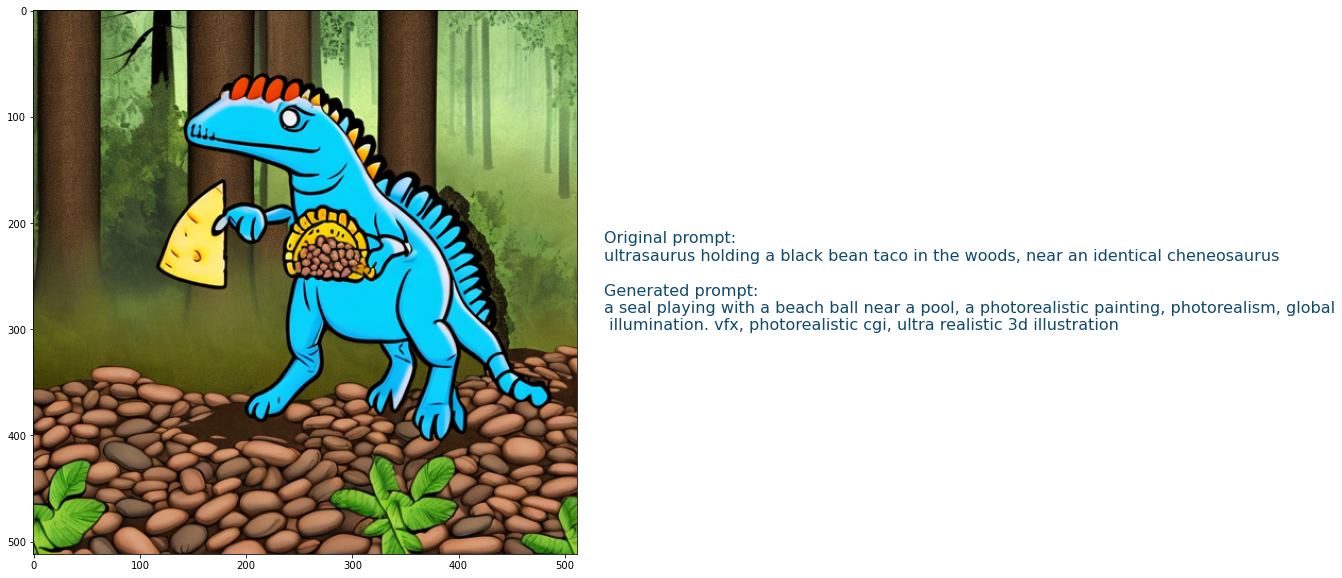

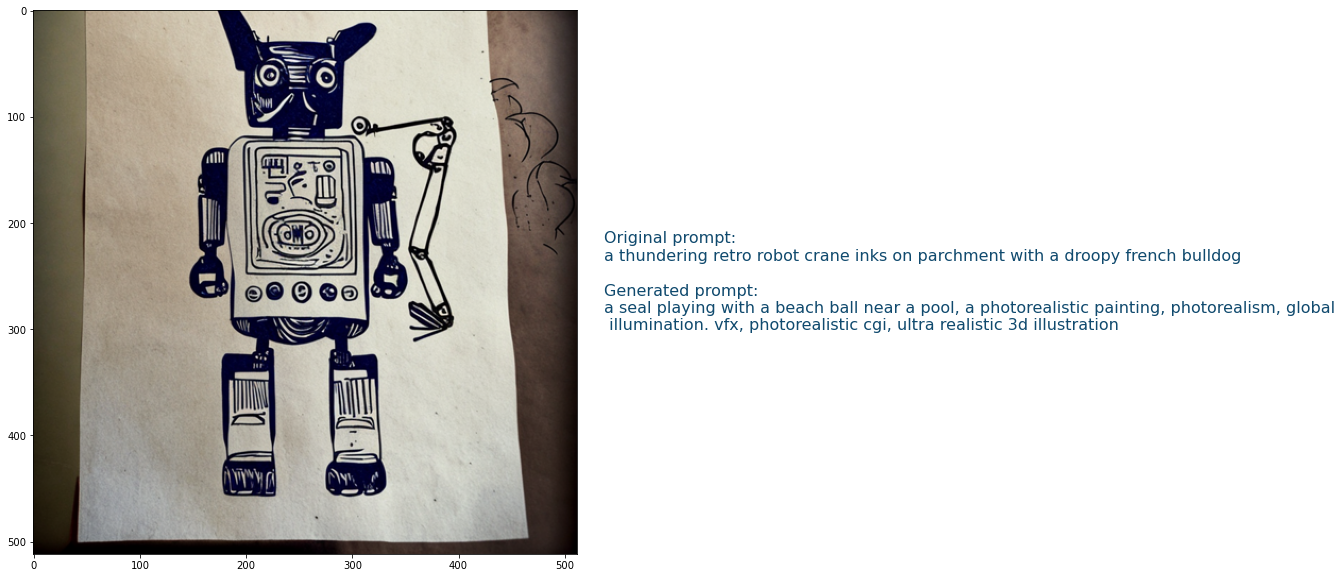

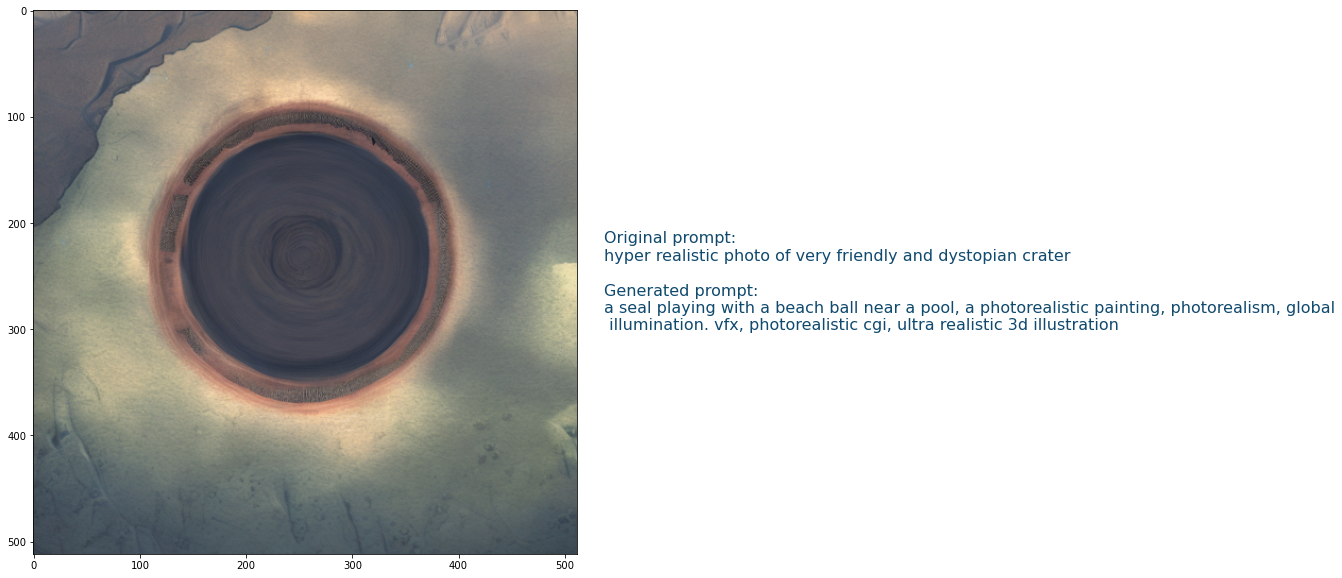

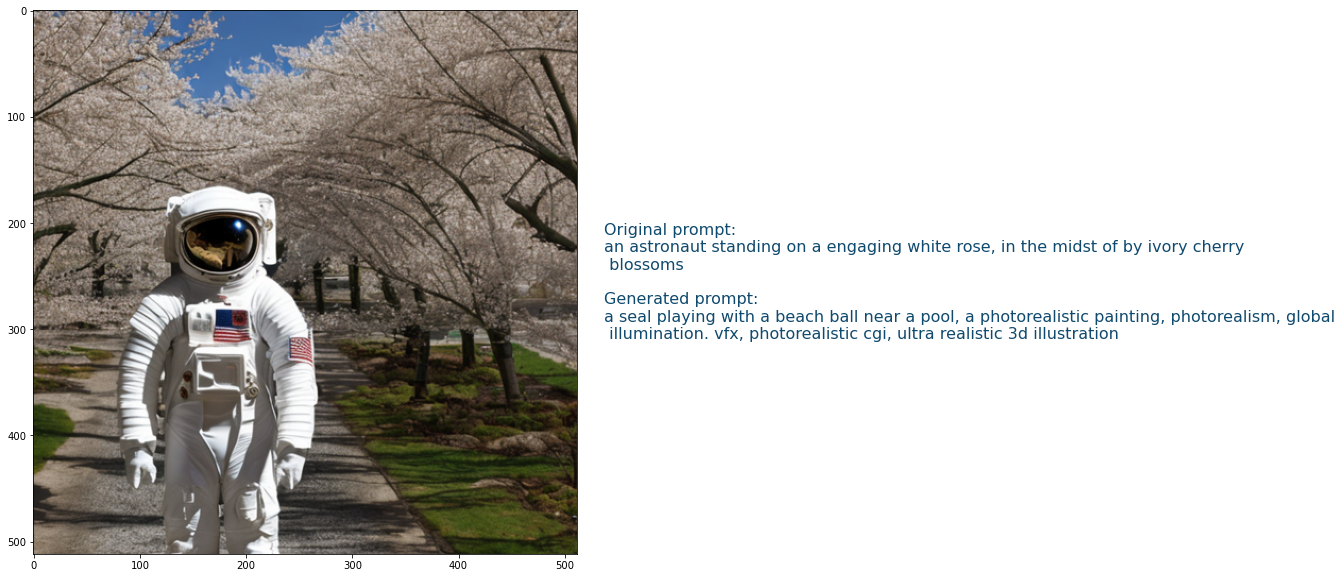

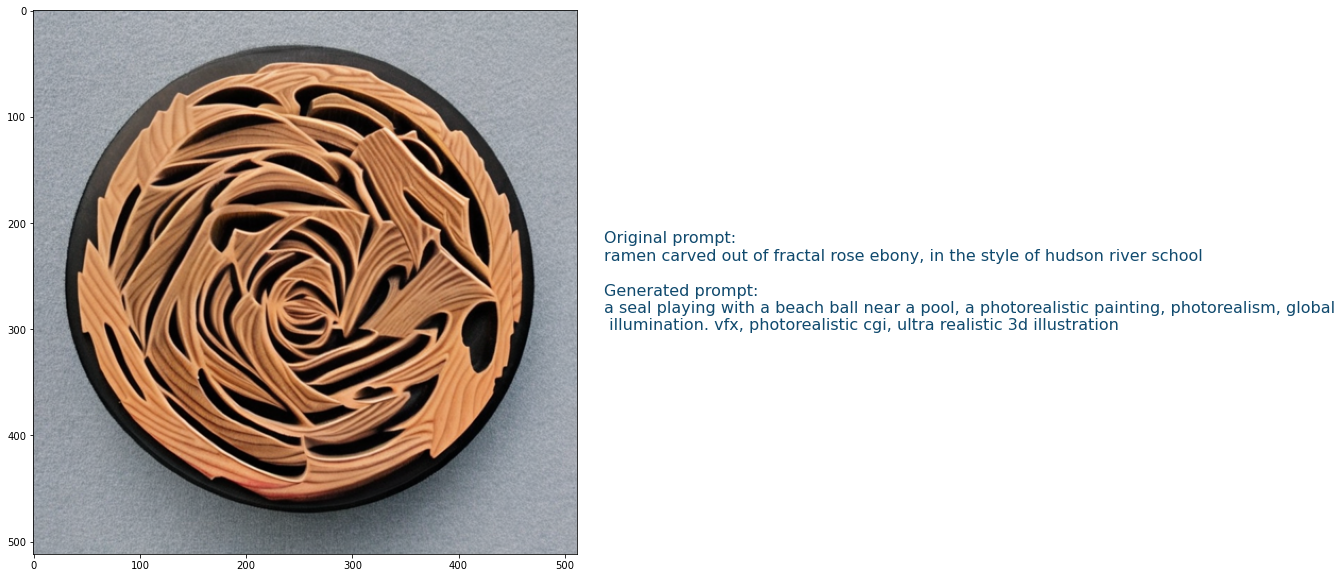

In [27]:
# DO NOT FORGET TO COMMENT OUT THIS CELL DURING SUBMISSION
print(prompts)
original_prompts_df = pd.read_csv("/kaggle/input/stable-diffusion-image-to-prompts/prompts.csv")

for image_name, prompt in zip(images, prompts):
    img = Image.open(images_path + image_name).convert("RGB")
    original_prompt = original_prompts_df[
        original_prompts_df.imgId == image_name.split(".")[0]
    ].prompt.iloc[0]
    plot_image(img, original_prompt, prompt)

<a id="10"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> 10. Create a sample submission with a constant prompt prediction</b></div>

<a id="10.1"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 10.1 Encode prompts</b></div>

In [ ]:
prompt_embeddings = st_model.encode(prompts).flatten()

<a id="10.2"></a>
## <div style="box-shadow: rgba(0, 0, 0, 0.18) 0px 2px 4px inset; padding:20px; font-size:24px; font-family: consolas; text-align:center; display:fill; border-radius:15px; color:rgb(67, 66, 66)"> <b> 10.2 Create submission DataFrame and save it as a .csv file</b></div>

In [ ]:
submission = pd.DataFrame(
    index=imgId_eId,
    data=prompt_embeddings,
    columns=['val']
).rename_axis('imgId_eId')

In [ ]:
submission.to_csv('submission.csv')